Dongjun Cho, Programming Assignment 2, Algorithms 605.621
# Statement of Academic Integrity
Place your statement of academic integrity here

I, Dongjun Cho, attempted to answer each question honestly and to the best of my abilities. I cited any and all help that I received in completing this assignment. 

# Instructions to Students
This programming assignment is contained entirely in this IPython/Jupyter notebook. You are to read the problem from this notebook, and answer questions/make required modifications in this same notebook and submit it as a notebook.  Look for **BOLDFACE AND/OR ALL CAPS** for where to put your answers.  Do not delete the problem statements, text, etc, leave all that as-is (makes grading easier), unlike with the homeworks.

# Overview

[The Maryland Lighthouse Challenge](https://cheslights.org/maryland-lighthouse-challenge/) is a biennial event where people race around the state of Maryland attempting to visit all 10 historic lighthouses and one lightship spread out among the most beautiful parts of the state.  The goal is to be the first team to visit all of the lighthouses during the challenge weekend.  One of your [professors and his wife](https://www.facebook.com/cheslights/photos/a.2861267277221280/2995180270496646/?type=1&theater) have [competed very favorably](https://cheslights.org/1st-finishers-results-2019-md-lighthouse-challenge/) in these events ;-)  

The lighthouse challenge can be modeled as an instance of the *traveling salesperson problem (TSP)* that recurs frequently in networking, semiconductor layouts,and efficient routing.  This two-part problem will have you explore different strategies for identifying the fastest *tour*&mdash;the path and starting point that leads contestants to visit all lighthouses finishing at the earliest possible time, with algorithms that run in a reasonable amount of wall-clock time.

In part one, you'll implement a brute-force algorithm for *solving* TSP&mdash;in our case, the fastest tour covering all the lighthouses.  Then, you'll explore how much improvement in processing time you can achieve using an optimization technique called "memoization" to avoid duplicate work.  In later programming assignments, you will explore other optimization techniques to use on the TSP problem.

# Lighthouse Challenge - Fastest Tour (100 pts total)
The algorithm has separate points assessed within a homework assignment.


## Assumptions
There are some Lighthouse Challenge details and assumptions:
1. The contest requires a visit of all lighthouses; the winner is the first team to visit all lights (the contestants do not need to return to the start point).
1. Teams may start at any lighthouse, and finish at any other lighthouse.
1. Travel time from A to B is the same as the time from B to A. 


## Implementation (50)
Implement your algorithm in the Student Implementation block(s) and code to print your results. Your code must have a reasonable, consistent, style and commented documentation. It must have appropriate data structures and modularity.  Feel free to use all of the block, and to create additional notebook cells as necessary.  Just put all your code between the instructor data structures and instructor run blocks.  Be sure to preserve the instructor input block, and do not change names of any of the variables - they will be inputted fresh by the instructor when testing your code.  Output must be clear and nicely formatted.  

Your code should have be robust and have some error checking - we won't deliberately test for unusual/nonsense conditions, but our tests will include different data than supplied here so you want to be prepared for a variety of (well-formed) input conditions.

Important notes:
 * **You must implement your algorithm** that you submitted earlier, allowing for minor corrections.
 * **When submitting, take out any debug statements below,** left in for your convenience (and to validate the correctness of this assignment notebook).  During development, you may find it useful to add your own debug statements.
 * **Your notebook must take less than 5 minutes to run** on Colaboratory.  If it takes significantly longer, there might be a bug.

Print the best tour and time, using the TRAVEL_TIME and L provided in the instructor input block, so that the correctness of your implementation can be validated.

In [1]:
############################################################################
# INSTRUCTOR DATA STRUCTURES AND INITIAL TEST DATA
# DO NOT CHANGE THE NAMES OR SIGNATURES OF THESE STRUCTURES OR FUNCTIONS.
############################################################################
TRAVEL_TIME = {
    ('Lightship Chesapeake', 'Concord Point'): 0.8,
    ('Lightship Chesapeake', 'Point Lookout'): 2.3,
    ('Lightship Chesapeake', 'Sandy Point'): 0.7166666666666667,
    ('Lightship Chesapeake', 'Drum Point'): 1.62,
    ('Concord Point', 'Point Lookout'): 3.1166666666666667,
    ('Concord Point', 'Sandy Point'): 1.45,
    ('Concord Point', 'Drum Point'): 2.23,
    ('Point Lookout', 'Sandy Point'): 2.1166666666666667,
    ('Point Lookout', 'Drum Point'): 0.7666666666666667,
    ('Sandy Point', 'Drum Point'): 1.4333333333333333
}

# Helper Functions
def list_minus(L, x):
    """Returns a list of L that does not have x in it."""
    return list(set(L)-set([x,]))

def fix_lookup(TRAVEL_TIME):
  """
  Returns a TRAVEL_TIME indexed by both (a,b) and (b,a).  If your algorithm
  wants TRAVEL_TIME[('foo', 'bar')], and TRAVEL_TIME has an index only for
  [('bar', 'foo)], it will throw an exception.  This method fixes that by 
  duplicating keys and reversing their order.  (There are Pythonic ways 
  of doing this, such as frozensets, but that gets syntactically ugly.)

  Use:
    TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
  """
  TTA = {(k[1],k[0]):TRAVEL_TIME[k] for k in TRAVEL_TIME.keys()} # reverse/dup 
  TRAVEL_TIME.update(TTA)
  return TRAVEL_TIME

# Global Variables
TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))

In [2]:
# Utility functions that you can use if you wish

def random_lighthouses(n):
    """
    Generates a random subset of n lighthouses.  Returns a dictionary of 
    travel times, and new list of names, for the subset.

    Use:
      myTravelTime, myLights = random_lighthouses(3)
    """
    global TRAVEL_TIME, LIGHTS

    if n>len(LIGHTS):
        raise Exception("Exceeded max number of lights")

    # select subset of lights
    from random import sample
    subLights = sample(LIGHTS, n)

    # create and return a proper dictionary (w/(a,b) (b,a) lookups)
    newTT = {(i,j):TRAVEL_TIME[(i,j)] for i in subLights for j in list_minus(subLights, i)}
    return fix_lookup(newTT), list(set([item for k in newTT.keys() for item in k]))


In [3]:
############################################################################
# STUDENT IMPLEMENTATION BLOCK
############################################################################

# For this assignment, I tried to count the executions steps for three algorithms. 
# So, I named counting function calls differently. 
#    count_bf: Recursive Brute-force algorithm
#    count_nn: Nearest Neigbhor algorithm
#    count_mf: Multi-fragment Heuristic algorithm

from math import inf

# global variables
indent=""   # for debug statements
#For count for recursive brute force algorithm 
count_bf=0     # for counting function calls

## Recursive Function
def fastest_tour(start_light, L):
    global indent, count_bf
    # Accepts start_point (starting lighthouse name), list L (all lighthouses less start_point)
    # Returns best_tour (sequential list of lighthouses) and best_time (float value of best time in hours)
    # You must keep the signatures the same (accepts start_light, L and returns best_tour, best_time;
    #     start_light is a string, best_tour and L are lists of strings, and best_time is a float)
    # You must provide a recursive algorithm and must evaluate every possible route
    # Otherwise, you are free to change anything in here-- change variables, use a different structure,
    #     switch to object-oriented coding, etc.
    # Be sure that your pseudocode matches your actual code!

    """I will add reasonable comments here, and always be sure to check for errors."""
    """I will not change the function signature or its return parameters."""
    """If I have any questions, I'll ask my instructor or come to office hours."""

    count_bf = count_bf + 1 # count the number of calls
    
    #print(indent, f"fastest_tour({start_light}, {L})") # DEBUGGING - DELETE ME
    best_tour = []  # used to store the running best overall tour that starts at start_light
    best_time = inf # used to store the time for the best_tour sequence

    # TERMINATION CASE
    #    1. If the number of cities for the lighthouse is less than 2, it terminates the recursive function. 
    #    2. It returns the tour and tour time of the lighthouse.
    if len(L)<2:
        return [start_light, L[0]], TRAVEL_TIME[(start_light,L[0])]
    
    # RECURSIVE CASE ("else" is implied because we returned if terminating)
    #    1. It iterates through every possible city in the lighthouse.
    #    2. It computes the tour time between start points to the next points.
    #    3. It compares current tour time and best time to shortest/optimal tour time and tour.
    #    4. It returns the best tour time and best tour from start points.
    for next_light in L: 
            indent += "  "
            L_minus = list_minus(L, next_light)
            tour, time = fastest_tour(next_light, L_minus) 
            time += TRAVEL_TIME[(start_light,next_light)] 
            indent = indent[:-2]
            if time < best_time: 
                best_time = time
                best_tour = tour
    best_tour =[start_light] + best_tour
    #print(indent, f"return {[start_light]} + {best_tour}")  # DEBUGGING - DELETE ME
    return best_tour, best_time  
    """The input for the function, return value for the base case, and return value for"""
    """the recursive case must match exactly."""


## Kickoff Function, and Output
#print(LIGHTS)
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour, best_time = fastest_tour(start_light, L_minus)

print("The best tour is: ", ', '.join(best_tour))
print("The best time is: ", best_time)
print("The call counts are: ", count_bf)
# create an array for plotting below, add "count" to it, reset it for the next run
# run repeated trials over N, resetting counts each time, appending to mycounts

The best tour is:  Concord Point, Lightship Chesapeake, Sandy Point, Drum Point, Point Lookout
The best time is:  3.716666666666667
The call counts are:  41


## Test and Evaluation (40)
To estimate the computational complexity of your algorithm, you will need to run it against a number of different scenarios and capture a measure of the work done for each run.  Using the provided utility function, generate random sets of 3-10 lighthouses and then run your algorithm on them.  Gather the execution steps that your algorithm expends on them and then plot the results.  Finally, provide an analysis of your algorithm's running time and performance.  


In [4]:
#For Random Lighthouse function 
#Test 3
TRAVEL_TIME = { 
      ('F', 'E') : 7.453320453415392 ,
      ('F', 'D') : 6.170569410345761 ,
      ('F', 'I') : 10.448429302986911 ,
      ('F', 'G') : 6.187750187309644 ,
      ('F', 'C') : 12.090422838563583 ,
      ('F', 'H') : 11.539119418380032 ,
      ('F', 'A') : 13.23865323724485 ,
      ('F', 'J') : 14.209616157057711 ,
      ('F', 'B') : 12.029520235766265 ,
      ('E', 'D') : 4.594971038617467 ,
      ('E', 'I') : 9.488857351897519 ,
      ('E', 'G') : 4.661282508675182 ,
      ('E', 'C') : 10.705763401441896 ,
      ('E', 'H') : 10.12354365573923 ,
      ('E', 'A') : 12.05863087182219 ,
      ('E', 'J') : 12.857918364285274 ,
      ('E', 'B') : 10.915808926216425 ,
      ('D', 'I') : 8.773798408565863 ,
      ('D', 'G') : 3.549820998388679 ,
      ('D', 'C') : 9.084763991756446 ,
      ('D', 'H') : 8.47244200438249 ,
      ('D', 'A') : 10.768085646027655 ,
      ('D', 'J') : 11.205467989446557 ,
      ('D', 'B') : 9.811703475051996 ,
      ('I', 'G') : 4.856711290250502 ,
      ('I', 'C') : 10.303247633652786 ,
      ('I', 'H') : 9.72873923304563 ,
      ('I', 'A') : 11.752971702744057 ,
      ('I', 'J') : 12.386140947772116 ,
      ('I', 'B') : 10.715926552978804 ,
      ('G', 'C') : 8.939922836985131 ,
      ('G', 'H') : 8.325372714362043 ,
      ('G', 'A') : 10.658709470483634 ,
      ('G', 'J') : 11.05300320168352 ,
      ('G', 'B') : 9.726036954632448 ,
      ('C', 'H') : 14.85107596522508 ,
      ('C', 'A') : 16.127909792272288 ,
      ('C', 'J') : 17.54748278310382 ,
      ('C', 'B') : 14.699070399680458 ,
      ('H', 'A') : 15.723529687188293 ,
      ('H', 'J') : 17.10791004081554 ,
      ('H', 'B') : 14.306778662449995 ,
      ('A', 'J') : 16.949188359233272 ,
      ('A', 'B') : 14.239542023142393 ,
      ('J', 'B') : 16.6207970728817 ,
}

In [5]:
# MY CODE BLOCK TO EXPERIMENT WITH 3-10 LIGHTHOUSES AND GATHER EXECUTION STEPS
#   It uses the given random_lighthouse function to generate 3-10 lighthouses. 
#   To generate 3-10 random lighthouses, I used Test3 data. 
#   In the random_lighthouse function, it returns both tour time and tour. 
#   It extracts the tour data from the random_lighthouse function. 
#   Since the fasterst_tour function is called in the top, It subtracts the previous function count to gather execution steps.  
#   It gathers the execution steps for random 3-10 lighthouse, and it stores them in execution_steps_bf for plotting graph. 

execution_steps_bf=[]
steps_bf =[]
for i in range(3,11):
    TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
    LIGHTS = list(set([item  for  k  in  TRAVEL_TIME.keys()  for  item  in  k])) 
    LIGHTS = random_lighthouses(i)[1]
    start_light = LIGHTS[0] 
    L_minus = list_minus(LIGHTS, start_light)
    best_tour, best_time = fastest_tour(start_light, L_minus)
    execution_steps_bf.append(count_bf - 41)
    steps_bf.append(i)
print(execution_steps_bf)
print(steps_bf)

[3, 13, 54, 260, 1497, 10157, 79438, 702968]
[3, 4, 5, 6, 7, 8, 9, 10]


### Plot
Plot the execution steps below.

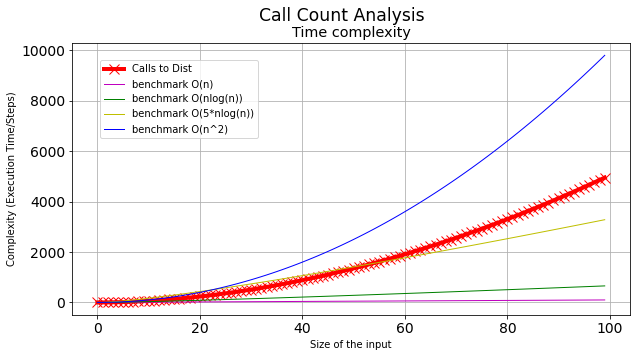

In [6]:
# Code adapted from Sahil Sharma, used with permission, from Spring, 2021

from math import pow
from math import log2
from math import factorial

# Let myruncounts[i] be count of calls for POINT array of size i
myruncounts = [0.8*x**1.9 for x in range(100)] # your data here

# benchmark data set generation
yTestVals1 = [0,] # linear for O(n)
yTestVals2 = [0,] # quadratic for O(n^2)
yTestVals3 = [0,] # n*log(n) for O(nlog(n))
yTestVals4 = [0,] # 5*n*log(n) for O(nlog(n))

# generate bench mark data for O(n), O(n^2), O(nlog(n)), O(10*nlog(n)), and O(n!)
for i in range(1, len(myruncounts)):
    yTestVals1.append(i)
    yTestVals2.append(pow(i, 2))
    yTestVals3.append(i*log2(i))
    yTestVals4.append(5*i*log2(i))

# %matplotlib inline
import matplotlib.pyplot as plt

# Simple vs. Improved execution steps
plt.rcParams['figure.figsize'] = [10,5]
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Call Count Analysis', size="xx-large")

# plotting nearest neighbor execution steps
ax1.set_title('Time complexity', size="x-large")
ax1.plot(range(len(myruncounts)), myruncounts, "rx-", markersize=10, linewidth=4, label="Calls to Dist")
ax1.plot(range(len(myruncounts)), yTestVals1, "m^-", markersize=0, linewidth=1, label="benchmark O(n)")
ax1.plot(range(len(myruncounts)), yTestVals3, "g^-", markersize=0, linewidth=1, label="benchmark O(nlog(n))")
ax1.plot(range(len(myruncounts)), yTestVals4, "y^-", markersize=0, linewidth=1, label="benchmark O(5*nlog(n))")
ax1.plot(range(len(myruncounts)), yTestVals2, "b^-", markersize=0, linewidth=1, label="benchmark O(n^2)")
ax1.grid(b=True, which='major', axis='both')
## X label for this graph is Complexity respect to input size in other words, Runtime. 
## Y label for this graph is input size. 
ax1.set(xlabel = 'Size of the input', ylabel = 'Complexity (Execution Time/Steps)')
ax1.legend(loc=(0.05,0.65), scatterpoints=1)
ax1.tick_params(axis="both", which="major", labelsize=14)

### Analysis and Running Time
**HERE IS MY EXPLANATION OF WHAT IS HAPPENING ABOVE.  WHAT IS THE THEORETICAL RUNNING TIME OF THE ALGORITHM? MY RUNNING TIME IS $O(n), \Theta(n)$, or  $\Omega(n)$, AND BRIEFLY WHY...**

**Here is what the plot shows.** Remember, plots (and your writeup) must tell a (short) story.

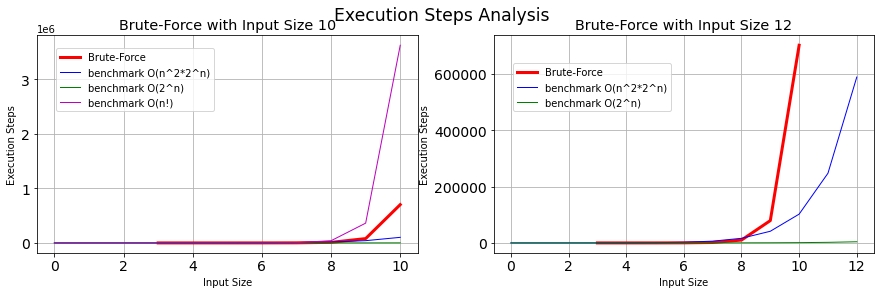

In [7]:
#Input size 10
new_myruncounts_1 = [0.8*x**1.9 for x in range(11)] 

TestVal1_1 = [0,] # quadratic for O(2^n*n^2)
TestVal1_2 = [0,] # quadratic for O(n^2)
TestVal1_3 = [0,] # quadratic for O(n!)

for i in range(1, len(new_myruncounts_1)):
    TestVal1_1.append(pow(i, 2)*pow(2, i))
    TestVal1_2.append(pow(2, i))
    TestVal1_3.append(factorial(i))

#Input size 12
new_myruncounts_2 = [0.8*x**1.9 for x in range(13)] 

TestVal2_1 = [0,] # quadratic for O(2^n*n^2)
TestVal2_2 = [0,] # quadratic for O(n^2)
TestVal2_3 = [0,] # quadratic for O(n!)

for i in range(1, len(new_myruncounts_2)):
    TestVal2_1.append(pow(i, 2)*pow(2, i))
    TestVal2_2.append(pow(2, i))

plt.rcParams['figure.figsize'] = [10,5]
# fig, (ax1) = plt.subplots(1, 1)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
fig.suptitle('Execution Steps Analysis', size="xx-large")

ax1.plot(steps_bf, execution_steps_bf, "rx-", markersize=0, linewidth=3, label="Brute-Force")
ax1.plot(range(len(new_myruncounts_1)), TestVal1_1, "b^-", markersize=0, linewidth=1, label="benchmark O(n^2*2^n)")
ax1.plot(range(len(new_myruncounts_1)), TestVal1_2, "g^-", markersize=0, linewidth=1, label="benchmark O(2^n)")
ax1.plot(range(len(new_myruncounts_1)), TestVal1_3, "m^-", markersize=0, linewidth=1, label="benchmark O(n!)")
ax1.grid(b=True, which='major', axis='both')
ax1.legend(loc=(0.05,0.85), scatterpoints=1)

ax2.plot(steps_bf, execution_steps_bf, "rx-", markersize=0, linewidth=3, label="Brute-Force")
ax2.plot(range(len(new_myruncounts_2)), TestVal2_1, "b^-", markersize=0, linewidth=1, label="benchmark O(n^2*2^n)")
ax2.plot(range(len(new_myruncounts_2)), TestVal2_2, "g^-", markersize=0, linewidth=1, label="benchmark O(2^n)")
ax2.grid(b=True, which='major', axis='both')
ax2.legend(loc=(0.05,0.85), scatterpoints=1)

ax1.set_title('Brute-Force with Input Size 10', size="x-large")
ax2.set_title('Brute-Force with Input Size 12', size="x-large")

ax1.set(xlabel = 'Input Size', ylabel = 'Execution Steps')
ax1.legend(loc=(0.05,0.65), scatterpoints=1)
ax1.tick_params(axis="both", which="major", labelsize=14)

ax2.set(xlabel = 'Input Size', ylabel = 'Execution Steps')
ax2.legend(loc=(0.05,0.65), scatterpoints=1)
ax2.tick_params(axis="both", which="major", labelsize=14)

To estimate the computational complexity of my brute-force algorithm, I tried to run this algorithm using random scenarios. To generate the random scenarios, I used the given random lighthouse function. Since the TRAVEL_TIME in the top contains 5 cities, I couldn't generate 10 random cities using TRAVEL_TIME in the top. Since test3 TRAVEL_TIME contains 10 cities, I used the test3 data to generate up to 10 lighthouses. Using the given random_lighthouse function and test3 data, I was able to generate a random set of 3-10 lighthouses. I measured the execution steps from 3 to 10 lighthouses and analyzed the execution steps. Theoretically, the computational complexity of the recursive brute-force algorithm should be O($n^2$$2^n$) because there are n possible start vertices and $2^n$ vertices. Since the execution steps of brute-force are huge, I tried to compare brute-force, O($n^2$$2^n$), O($2^n$), and O(n!). 

After analyzing the execution steps of the recursive brute-force algorithm execution steps, I realized that the execution steps for brute-force are huge that don't fit into the Call Count Analysis Graph. Since the O($n!$) is the largest time complexity we can measure, I tried to compare execution steps of brute-force and O($n!$) with an input size of 10. So, I tried to graph with O($n!$), O($n^2$$2^n$), and O($2^n$). When we compare with O($n!$), it is very hard to see other time complexity such as O($n^2$$2^n$) and O($2^n$). So, I tried to plot another graph without O($n!$). Since the other graph doesn't really show other time complexity other than execution steps of brute-force, I tried to increase the size of the input. After increasing the input size to 12, I realized that the O($n^2$$2^n$) becomes close to brute-force. 

By analyzing the execution steps of my brute-force algorithm, I realized that the time complexity shows between O($n^2$$2^n$) and O(n!). So, I realized that the computational complexity of my brute-force algorithm $\Theta$($n^2$$2^n$).

In [8]:
# Since we called Test3 lighthouse data, the TRAVEL_TIME is test3 data. 
# To analyze the algorithm with simple data with 5 cities, I copied first TRAVEL_TIME from the top. 

#For Normal lighthouse runs
TRAVEL_TIME = {
    ('Lightship Chesapeake', 'Concord Point'): 0.8,
    ('Lightship Chesapeake', 'Point Lookout'): 2.3,
    ('Lightship Chesapeake', 'Sandy Point'): 0.7166666666666667,
    ('Lightship Chesapeake', 'Drum Point'): 1.62,
    ('Concord Point', 'Point Lookout'): 3.1166666666666667,
    ('Concord Point', 'Sandy Point'): 1.45,
    ('Concord Point', 'Drum Point'): 2.23,
    ('Point Lookout', 'Sandy Point'): 2.1166666666666667,
    ('Point Lookout', 'Drum Point'): 0.7666666666666667,
    ('Sandy Point', 'Drum Point'): 1.4333333333333333
}
TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))

## Nearest Neighbor (improved algorithm)

After finishing implementing the recursive brute-force algorithm, I tried to write an improved algorithm. I tried to implement other improved algorithms because I wasn't sure how to design/implement the Multi-Fragment Heuristic algorithm at first. For the improved algorithm, I choose the nearest neighbor algorithm that is shown in the pdf that Professor provided.

In [9]:
# Nearest Neighbor is the algorithm that chooses the closest cities from the start cities. 
# Nearest Neighbor (fastest_tour_NN)
#    1. At first, it stores the start light(city) in the visited array
#    2. It keeps iterates until the length of the lighthouse is 0.
#    3. It iterates every lighthouse and it uses the same methods just like the recursive brute-force algorithm. 
#    4. It computes the tour time between the start points and the next points.
#    5. It compares the current tour time and the best time to find the nearest points from the start point.
#    6. After it finds the nearest points from start points, it stores the nearest points in the visited and removes them from the lighthouse. 
#    7. It moves to the next edges to find the next nearest points. 
#    8. It returns the best tour and best tour time. 

count_nn=0
def fastest_tour_NN(start_light, L):
    global count_nn
    visited = []
    visited.append(start_light)
    while len(L) >0: 
        count_nn = count_nn + 1 # count the number of calls
        best_time = inf
        next_city= start_light
        for next_light in L: 
            distance = TRAVEL_TIME[(start_light, next_light)] 
            if distance < best_time:
                best_time = distance
                next_city = next_light
        start_light = next_city 
        visited.append(start_light)
        L.remove(start_light) 
    new_dist = TotalTourTime(visited) 
    return visited, new_dist

# Compute the total tour time (TotalTourTime)
#    1. It iterates the best tour.
#    2. It computes the distance between edges and the next edges.
#    3. It returns computed tour time. 

def TotalTourTime(L):
    totalDistance = 0
    for i in range(0, len(L) - 1): 
        totalDistance += TRAVEL_TIME[(L[i], L[i+1])]
    return totalDistance

In [10]:
#print(LIGHTS)
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour, best_time = fastest_tour_NN(start_light, L_minus)

print("The best tour is: ", ', '.join(best_tour))
print("The best time is: ", best_time)
print("The call counts are: ", count_nn)

The best tour is:  Concord Point, Lightship Chesapeake, Sandy Point, Drum Point, Point Lookout
The best time is:  3.716666666666667
The call counts are:  4


## Multi-Factor (bonus 10 points)
The Traveling Salesperson Problem is in the family of NP Complete problems.  As such, there is no known polynomial time solution to it.  However, people over the years have come up with approximations that run in polynomial time, and some run fairly efficiently. 

The paper, [An Empirical Study of the Multi-Fragment Tour Construction Algorithm for the Traveling Salesman Problem](https://scholar.google.com/scholar?q=An+Empirical+Study+of+the+Multi-Fragment+Tour) by Krari *et al*, describes an interesting greedy algorithm that works by adding edges of increasing length to fill out the tour.

For this part:
 * implement the Multi-Fragment approximation method in Python, adapted to the Lighthouse challenge
 * compare accuracy vs. the brute-force algorithm
 * compare the execution steps vs. the brute-force algorithm 

(By "adapted to the Lighthouse challenge," our tours are not a cycle$-$they do not return to the starting point.)
 
For the accuracy tests, give an average percent difference of total tour times of Multi-Fragment vs. brute-force across a varied set of points.  Create a set of N nodes, and create edges with random travel times.   Run several trials per each of N varying between 4 and 10 inclusive.

For instance, for 5 points, create 5! edges with random weights, run brute force vs. Multi-Factor, obtain the total tour time for $T_{bf}$ and $T_{mf}$, then report the difference as $(T_{mf}-T_{bf})/T_{bf}$ in terms of percent.  Repeat the 5 points trial for a *decent* number of times - 10 runs is probably enough.  Average percents over all trials, over all tested number of points.  Try for 4 points, 5 points, ... to 10 points.

Count execution steps when performing the accuracy steps.  Plot steps of brute force, steps of multi-fragment, vs. number of points N (between 4 and 10 as above).  There should be no need to average, the algorithms should take the same number of steps for a given set of N. 

Copy/paste plot and/or brute-force code from above.  You may reuse from within your own notebook.

Complete a small writeup in the analysis section.

In [11]:
# My Multi-Fragment Tour Code
#    1. It first sorts the TRAVEL TIME
#    2. From start cities, it iterates over shortest edges
#    3. If the edges create the cycles, it moves to next shortest edges
#    4. If the number of complete edges are equal to the number of edges, it completes the algorithm

# Sort the TRAVEL_TIME (sorted_TRAVEL_TIME)
#    1. From the TRAVEL_TIME, it sortes the TRAVEL_TIME by the tour time for each city.
#    2. From the sorted travel time, it stores from vertex and to vertex in the edges list. 
#    3. It returns the edges lists that contain sorted TRAVEL_TIME. 

def sorted_TRAVEL_TIME(TRAVEL_TIME):
    edges_list=[]
    sorted_edges = sorted([(adj, v1) for v1, adj in TRAVEL_TIME.items()]) 
    for i in sorted_edges: 
        from_vertex = i[1][0] 
        to_vertex = i[1][1] 
        edges_list.append((from_vertex,to_vertex)) 
    return edges_list

# Detect cycle(detectcycle)
#    1. It iterates through the graph.
#    2. If the current edges aren't in the graph, it is not a cycle. 
#    3. If the current edges are in the graph, it is the cycle
#    4. It returns the result list that contains the boolean value. 

def detectcycle(graph):
    graph_cycle = set()
    result =[]
    for edges in graph: #Iterate over the graph
        if edges[1] not in graph_cycle: #If the certain edges in graph, not cycle
            #print("not cycle")
            result.append(False)
        else: #If the certain edges not in graph, it is cycle
            #print("cycle")
            result.append(True)
        graph_cycle.add(edges[0])
    return result


# This function is to return boolean for the detectcycle function. 
# If the graph creates a cycle, it returns True.
# If the graph doesn't create a cycle, it returns False.
def iscyclic(graph):
    if True in detectcycle(graph):
        return True

# Multi-Fragment Heuristic Algorithm (MF)
#    1. It iterates over the edges until the number of visited edges becomes the number of edges.
#    2. It loops through all edges and finds the edges that have start points. 
#    3. If it finds the edges that have start points, it stores them in the visited
#    4. It checks the visited list and removes current edges if it creates the cycles using iscyclic function.
#    5. It clears the start cities list for the next edges and moves to the next edges. 
#    6. Since the visited is in tuple form ((a,b), (b,c)), It changes from a tuple to a list. 
#    7. It computes the tour time using the TotalTourTime function. 
#    8. It returns the best tour and best tour time. 

count_mf =0
def MF(s,G):
    global count_mf
    visited=[]
    start_cities =[]
    best_tour = []
    j=0
    next_city = s
    while len(visited) < len(LIGHTS)-1:
        count_mf = count_mf + 1 
        for i in G: 
            if i[0] == next_city: 
                start_cities.append(i)
        visited.append(start_cities[0])
        for i in start_cities:
            if iscyclic(visited): 
                visited.pop() 
                visited.append(i)
            else:
                break
        start_cities.clear()
        next_city = visited[j][1] 
        j+=1
    best_tour = []
    for i in list(j for i in visited for j in i):
        if i not in best_tour:
            best_tour.append(i)
    best_time = TotalTourTime(best_tour) #Compute the total tour time
    return best_tour, best_time

In [12]:
start_light = LIGHTS[0] 
best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME))
print("The best tour is: ", ', '.join(best_tour_mf))
print("The best time is: ", best_time_mf)
print("Function calls ", count_mf)

The best tour is:  Concord Point, Lightship Chesapeake, Sandy Point, Drum Point, Point Lookout
The best time is:  3.716666666666667
Function calls  4


### For Random Lighthouse

In [13]:
#For Random Lighthouse function 
#Test 3
TRAVEL_TIME = { 
      ('F', 'E') : 7.453320453415392 ,
      ('F', 'D') : 6.170569410345761 ,
      ('F', 'I') : 10.448429302986911 ,
      ('F', 'G') : 6.187750187309644 ,
      ('F', 'C') : 12.090422838563583 ,
      ('F', 'H') : 11.539119418380032 ,
      ('F', 'A') : 13.23865323724485 ,
      ('F', 'J') : 14.209616157057711 ,
      ('F', 'B') : 12.029520235766265 ,
      ('E', 'D') : 4.594971038617467 ,
      ('E', 'I') : 9.488857351897519 ,
      ('E', 'G') : 4.661282508675182 ,
      ('E', 'C') : 10.705763401441896 ,
      ('E', 'H') : 10.12354365573923 ,
      ('E', 'A') : 12.05863087182219 ,
      ('E', 'J') : 12.857918364285274 ,
      ('E', 'B') : 10.915808926216425 ,
      ('D', 'I') : 8.773798408565863 ,
      ('D', 'G') : 3.549820998388679 ,
      ('D', 'C') : 9.084763991756446 ,
      ('D', 'H') : 8.47244200438249 ,
      ('D', 'A') : 10.768085646027655 ,
      ('D', 'J') : 11.205467989446557 ,
      ('D', 'B') : 9.811703475051996 ,
      ('I', 'G') : 4.856711290250502 ,
      ('I', 'C') : 10.303247633652786 ,
      ('I', 'H') : 9.72873923304563 ,
      ('I', 'A') : 11.752971702744057 ,
      ('I', 'J') : 12.386140947772116 ,
      ('I', 'B') : 10.715926552978804 ,
      ('G', 'C') : 8.939922836985131 ,
      ('G', 'H') : 8.325372714362043 ,
      ('G', 'A') : 10.658709470483634 ,
      ('G', 'J') : 11.05300320168352 ,
      ('G', 'B') : 9.726036954632448 ,
      ('C', 'H') : 14.85107596522508 ,
      ('C', 'A') : 16.127909792272288 ,
      ('C', 'J') : 17.54748278310382 ,
      ('C', 'B') : 14.699070399680458 ,
      ('H', 'A') : 15.723529687188293 ,
      ('H', 'J') : 17.10791004081554 ,
      ('H', 'B') : 14.306778662449995 ,
      ('A', 'J') : 16.949188359233272 ,
      ('A', 'B') : 14.239542023142393 ,
      ('J', 'B') : 16.6207970728817
}

In [14]:
# Just like the recursive brute-force algorithm, I tried to gather execution steps. 
# It uses the given random_lighthouse function to generate 3-10 lighthouses. 
# It generates random sets of 3-10 lighthouses and then run the algorithm
# Since we call the function at the top, I subtract the previous calls.

execution_steps_mf=[]
steps_mf =[]
for i in range(3,11):
    TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
    LIGHTS = list(set([item  for  k  in  TRAVEL_TIME.keys()  for  item  in  k])) 
    TRAVEL_TIME_rand, LIGHTS  = random_lighthouses(i)
    start_light = LIGHTS[0] 
    best_tour, best_time = MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME_rand))
    execution_steps_mf.append(count_mf-4)
    steps_mf.append(i)
print(execution_steps_mf)
print(steps_mf)

[2, 5, 9, 14, 20, 27, 35, 44]
[3, 4, 5, 6, 7, 8, 9, 10]


[Text(0, 0.5, 'Execution Steps'), Text(0.5, 0, 'Input Size(Number of Points)')]

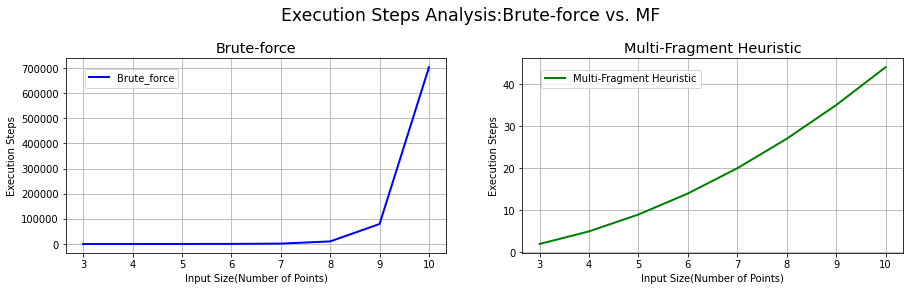

In [15]:
# My Plot Code
# At first, I tried to combine both brute-force execution steps and multi-fragment execution steps.
# Since the difference between the two graphs is huge, I tried to separate the two graphs. 

plt.rcParams['figure.figsize'] = [10,5]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4)) # plt.subplots(1, 1)
fig.suptitle('Execution Steps Analysis:Brute-force vs. MF', size="xx-large")
plt.subplots_adjust(top=0.8)

ax1.set_title('Brute-force', size="x-large")
ax2.set_title('Multi-Fragment Heuristic', size="x-large")

ax1.plot(steps_bf, execution_steps_bf, "b^-", markersize=0, linewidth=2, label="Brute_force")
ax2.plot(steps_mf, execution_steps_mf, "g^-", markersize=0, linewidth=2, label="Multi-Fragment Heuristic")

ax1.grid(b=True, which='major', axis='both')
ax1.legend(loc=(0.05,0.85), scatterpoints=1)
ax1.set(xlabel = 'Input Size(Number of Points)', ylabel = 'Execution Steps')

ax2.grid(b=True, which='major', axis='both')
ax2.legend(loc=(0.05,0.85), scatterpoints=1)
ax2.set(xlabel = 'Input Size(Number of Points)', ylabel = 'Execution Steps')

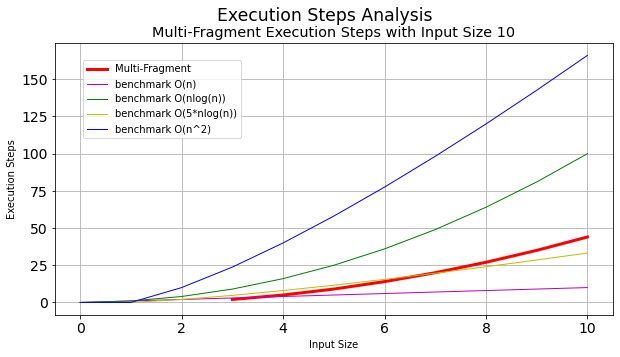

In [16]:
new_myruncounts_2 = [0.8*x**1.9 for x in range(11)] 

# benchmark data set generation
TestVal3_1  = [0,] # linear for O(n)
TestVal3_2 = [0,] # quadratic for O(n^2)
TestVal3_3 = [0,] # n*log(n) for O(nlog(n))
TestVal3_4 = [0,] # 5*n*log(n) for O(nlog(n))

for i in range(1, len(new_myruncounts_2)):
    TestVal3_1.append(i)
    TestVal3_2.append(pow(i, 2))
    TestVal3_3.append(i*log2(i))
    TestVal3_4.append(5*i*log2(i))

plt.rcParams['figure.figsize'] = [10,5]
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Execution Steps Analysis', size="xx-large")

ax1.plot(steps_mf, execution_steps_mf, "rx-", markersize=0, linewidth=3, label="Multi-Fragment")
ax1.plot(range(len(new_myruncounts_2)), TestVal3_1, "m^-", markersize=0, linewidth=1, label="benchmark O(n)")
ax1.plot(range(len(new_myruncounts_2)), TestVal3_2, "g^-", markersize=0, linewidth=1, label="benchmark O(nlog(n))")
ax1.plot(range(len(new_myruncounts_2)), TestVal3_3, "y^-", markersize=0, linewidth=1, label="benchmark O(5*nlog(n))")
ax1.plot(range(len(new_myruncounts_2)), TestVal3_4, "b^-", markersize=0, linewidth=1, label="benchmark O(n^2)")
ax1.grid(b=True, which='major', axis='both')
ax1.legend(loc=(0.05,0.85), scatterpoints=1)

ax1.set_title('Multi-Fragment Execution Steps with Input Size 10', size="x-large")

ax1.set(xlabel = 'Input Size', ylabel = 'Execution Steps')
ax1.legend(loc=(0.05,0.65), scatterpoints=1)
ax1.tick_params(axis="both", which="major", labelsize=14)

### Accuracy

In [17]:
# Accuracy 
#    It runs 10 trials for 4-10 random lighthouse points. 
#    It runs both the Brute-force algorithm and MF algorithm. 
#    It stores the tour time for each algorithm. 

Tbf_test = []
Tmf_test = []
for _ in range(10): #10 trials
    for i in range(4, 11): #From 4 points to 10 points
        TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
        LIGHTS = list(set([item  for  k  in  TRAVEL_TIME.keys()  for  item  in  k])) 
        TRAVEL_TIME_rand, LIGHTS  = random_lighthouses(i)
        start_light = LIGHTS[0] 
        L_minus = list_minus(LIGHTS, start_light)
        #Brute-force algorithm
        best_tour_bf, best_time_bf = fastest_tour(start_light, L_minus)
        #MF algorithm
        best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME_rand))
        Tbf_test.append(best_time_bf) 
        Tmf_test.append(best_time_mf)

# It stores the tour time data as 
# [4, 5, 6, 7, 8, 9, 10,4, 5, 6, 7, 8, 9, 10,..., 4, 5, 6, 7, 8, 9, 10]
        
#But, I need to change the tour time data into form of 
# [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Points 4
#   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Points 5
#   ...                              ....
#   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Points 10
#]

In [18]:
# To change the tour data form
# I break the tour time data by the number of trials which is 10.
# I transposes the matrix, so I can take the number of trials by the number of points.
n =10
Tbf_list = [Tbf_test[i:i + n] for i in range(0, len(Tbf_test), n)] 
Tmf_list = [Tmf_test[i:i + n] for i in range(0, len(Tmf_test), n)]

# After breaking tour time data by number of trials (Tbf_list/Tmf_list)
# [ [4, 5, 6, 7, 8, 9, 10], Trial 1
#   [4, 5, 6, 7, 8, 9, 10], Trial 2
#   .....                   ...
#   [4, 5, 6, 7, 8, 9, 10]  Trial 10 
#]

Tbf = [[Tbf_list[j][i] for j in range(len(Tbf_list))] for i in range(len(Tbf_list[0]))]
Tmf = [[Tmf_list[j][i] for j in range(len(Tmf_list))] for i in range(len(Tmf_list[0]))]

# After transposing the matrix, I was able to change the data form I wanted. (Tbf/Tmf)
# [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Points 4
#   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Points 5
#   ...                              ....
#   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  Points 10
#]

In [19]:
# Compute the accuracy
# To compute the accuracy, I need to compare brute-force and Multi-Fragment. 
# It computes the accuracy using Percent Error Formula.
# Error between brute-force and Multi-Fragment: (𝑇𝑚𝑓−𝑇𝑏𝑓)/𝑇𝑏𝑓
# It multiplies by 100 to represent the result in terms of percent. 

accuracy_n =[]
for i in range(0, 10):
    for j in range(0, len(Tbf[i])):
        accuracy = abs(Tmf[i][j]-Tbf[i][j]) / abs(Tbf[i][j]) 
        accuracy_percent = accuracy*100
        accuracy_n.append(accuracy_percent)     
# accuracy_n 
# [4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...,10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

# Since the accuracy_n list represents all the percent in one list, it needs to change the list form into a 2d matrix. 
# I changes the form into a 2d matrix to represent the percent for each point in the graph. 
# I computes the average of the accuracy of each point. 

n=10 
accuracy_list= [accuracy_n[i:i + n] for i in range(0, len(accuracy_n), n)]
# accuracy_list
# # [ [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 
#     [5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 
#     ...                            
#    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10] 
#]

computed_accuracy = []
for i in range(len(accuracy_list)):
    average_accuracy = sum(accuracy_list[i]) / len(accuracy_list[i])
    computed_accuracy.append(average_accuracy)

accuracy_percent_list=[]
for i in range(4, 11):
    accuracy_percent_list.append(i)
print(accuracy_percent_list)
print(computed_accuracy)

[4, 5, 6, 7, 8, 9, 10]
[2.3601291442247665, 4.232518936663228, 2.9001158261762576, 3.278734517350389, 3.497041029593183, 3.324210208523082, 4.174993120127721]


[Text(0, 0.5, 'Accuracy(%)'), Text(0.5, 0, '# of Points')]

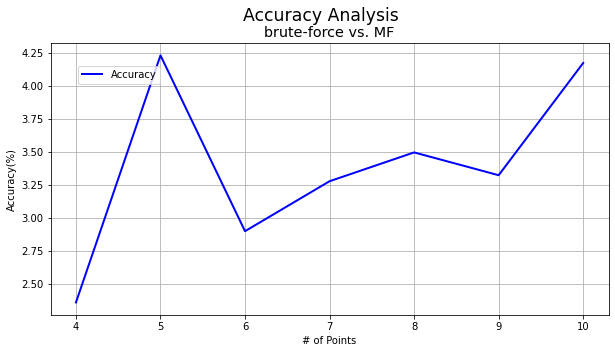

In [20]:
plt.rcParams['figure.figsize'] = [10,5]
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Accuracy Analysis', size="xx-large")
ax1.set_title('brute-force vs. MF', size="x-large")

ax1.plot(accuracy_percent_list, computed_accuracy, "b^-", markersize=0, linewidth=2, label="Accuracy")
ax1.grid(b=True, which='major', axis='both')
ax1.legend(loc=(0.05,0.85), scatterpoints=1)
ax1.set(xlabel = '# of Points', ylabel = 'Accuracy(%)')

In [21]:
# It computes the overall percent accuracy
overall_accuracy_percentage = sum(accuracy_n) / len(accuracy_n)
overall_accuracy_percentage

3.39539182609409

**Analysis:** **State your findings on accuracy and execution steps.  Talk to the graph a little.  Plots (and writeup) must tell a story.**

To analyze the accuracy of the brute-force and multi-fragment algorithm, I run the algorithm for 10 trials with 4 to 10 points. I was able to measure the average accuracy percent of all trials using the percent error formula((𝑇𝑚𝑓−𝑇𝑏𝑓)/𝑇𝑏𝑓). By measuring/analyzing the accuracy of all trials for all points, I know the overall percent error between brute-force value and multi-fragment value is around 4%.  

To analyze the computational complexity of the brute-force and multi-fragment(MF) algorithm, I run both algorithms using the random_lighthouse function with 3-10 points. Theoretically, the computational complexity of the recursive brute-force algorithm should be O($n^2$$2^n$) because there are n possible start vertices and $2^n$ vertices. Also, the computational complexity of the multi-fragment algorithm should be O($n^2$) because it gives the same permutation for each run. Based on the two graphs, it shows that the MF graph shows huge improvement compare to the brute-force graph. Based on the analysis of brute-force execution steps, we know the computational complexity of my brute-force algorithm $\Theta$($n^2$$2^n$).

To analyze the MF execution steps, I tried to compare with other complexity such as O($n$), O($nlog(n)$), O($5*nlog(n)$) and O($n^2$). I tried to plot the graph with an input size of 10 because I only measure the execution steps with 10 points. By analyzing the execution steps, I realized that the time complexity of the MF algorithm shows between O($nlog(n)$) and O($5*nlog(n)$). So, I realized that the computational complexity of my brute-force algorithm is $\Theta$($5*nlog(n)$).  

By analyzing the computational complexity of the brute-force and multi-fragment(MF) algorithm, I realized that the time complexity of recursive brute-force is $\Theta$($n^2$$2^n$) and MF is $\Theta$($5*nlog(n)$). By comparing the Theoretical result and experimental result, I was able to come up with the correct complexity for recursive brute-force, but not MF algorithm. I think I couldn't get the correct complexity for the MF algorithm because I implemented the MF algorithm and small input size. Even though I couldn't come up with the correct complexity for the MF algorithm, I learned that we can improve the performance of brute-force using the MF algorithm. 

Multi-Fragment Heuristic algorithm is one way to create an approximation solution to the Traveling salesman problem. By analyzing accuracy and execution steps, the Multi-Fragment algorithm finds tour differ by about 4% from the optimal solution. Also, it can significantly improve the time complexity of the brute-force algorithm. 

## Retrospection (10 total)
Talk about how you did on this assignment.  This is just feedback to the instructor.  You can edit this cell and answer inline in non-bold.
* **What was the last bug you found and fixed?**\
The bug that I found most is a logic error. For this assignment, the input type is a dictionary tuple. Since I was struggling to deal with dictionary tuple input, I kept getting logic errors during the implementation. I was able to fix this error by changing from the tuple data type to list data type.

* **What are some late-breaking ideas you had for improving your implementation, that maybe you didn't have time to implement?**\
For this assignment, I was able to figure out how to solve the traveling salesman problem using the recursive brute force algorithm and nearest neighbor algorithm. However, I didn't have time to implement the perfect multi-fragment heuristic algorithm. I know that there are three key components of the multi-fragment heuristic algorithm. The first component is the graph edges should be sorted. The second component is graph edges shouldn't create the cycle. The last component is the graph edge shouldn't be connected to more than two other edges. For the multi-fragment heuristic algorithm, I was able to include the first component and second component in my algorithm. But, I couldn't figure out how to include the last component in my algorithm. So, If I have time, then I will try to implement a perfect multi-fragment heuristic algorithm. 
* **What did you feel you learned from this assignment?**\
From this assignment, I learned how to deal with dictionary tuple input. In this assignment, I learned about how to approach the traveling salesman problem. I learned that I can solve TSP by using recursive brute force, nearest neighbor, and multi-fragment heuristic. By comparing the different types of the algorithm, I learned how to improve the certain type of algorithm to produce better time complexity and better performance. 
* **How would you improve this assignment for future semesters?**\
For this assignment, I constructed the pseudocode from the recursive brute-force algorithm and nearest neighbor algorithm before I started to implement it. However, I couldn't construct the perfect multi-fragment heuristic algorithm before I implement it. So, I had trouble structuring how to implement this algorithm. For the future assignment, I will try to construct the algorithm to figure out what is going on with the algorithm before I even start doing the implementation.

If there's anything else you'd like to say, feel free to write it.


# Citations

Using this [reference1](https://stackoverflow.com/questions/59333807/how-can-i-label-a-node-that-is-the-initial-vertex-in-a-cycle-from-graph-data), I was able to figure out how to detect the cycle in the graph array.

Using this [reference2](https://www.geeksforgeeks.org/break-list-chunks-size-n-python/), I was able to figure out how to break the tour_time by the number of trials.

Using this [reference3](https://www.geeksforgeeks.org/transpose-matrix-single-line-python/), I was able to figure out how to transpose the matrix, so I can take the number of trials by the number of points.

# Instructor Test Data
This is where the instructor will paste the test code and possibly additional data.  Some data with results are provided to help you debug, but we may test with different data.  Ensure your function works in this block.

In [22]:
# INSTRUCTOR-PROVIDED TEST DATA
# Ensure that your code matches both the input signature and the expected output
# For grading, different test data will be pasted into the input cell and your code cells will be executed
# Be sure that your input and output signatures match the provided sample data

# Test #1
TRAVEL_TIME = { 
      ('D', 'E') : 9.8874546134365 ,
      ('D', 'B') : 8.650955785569098 ,
      ('D', 'C') : 4.527990409960845 ,
      ('D', 'A') : 9.817667809230786 ,
      ('E', 'B') : 10.931854306263975 ,
      ('E', 'C') : 7.255251488484818 ,
      ('E', 'A') : 12.917982527478712 ,
      ('B', 'C') : 4.113565483054365 ,
      ('B', 'A') : 9.560863383439097 ,
      ('C', 'A') : 7.854345573910511 ,
}
# Expected output
# The best tour is:  A, B, C, D, E
# The best time is:  28.089873889890804

TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour_bf, best_time_bf = fastest_tour(start_light, L_minus)
best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME))
print("Test #1")
print("The best tour for brute-force is: ", ', '.join(best_tour_bf))
print("The best time for brute-force  is: ", best_time_bf)
print("The best tour for Multi-fragment is: ", ', '.join(best_tour_mf))
print("The best time for Multi-fragment is: ", best_time_mf)
print("")

# Test #2
TRAVEL_TIME = { 
      ('B', 'C') : 6.429795406216918 ,
      ('B', 'A') : 11.629846115160516 ,
      ('B', 'D') : 7.679251919404714 ,
      ('B', 'E') : 9.347706263090837 ,
      ('C', 'A') : 12.280646160363432 ,
      ('C', 'D') : 7.746192483295421 ,
      ('C', 'E') : 9.90681627370574 ,
      ('A', 'D') : 12.227183481562683 ,
      ('A', 'E') : 16.655823285647106 ,
      ('D', 'E') : 8.25715774835559 ,
}
# Expected output
# The best tour is:  A, B, C, D, E
# The best time is:  34.06299175302845

TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour_bf, best_time_bf = fastest_tour(start_light, L_minus)
best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME))
print("Test #2")
print("The best tour for brute-force is: ", ', '.join(best_tour_bf))
print("The best time for brute-force  is: ", best_time_bf)
print("The best tour for Multi-fragment is: ", ', '.join(best_tour_mf))
print("The best time for Multi-fragment is: ", best_time_mf)
print("")

# Test #3
TRAVEL_TIME = { 
      ('F', 'E') : 7.453320453415392 ,
      ('F', 'D') : 6.170569410345761 ,
      ('F', 'I') : 10.448429302986911 ,
      ('F', 'G') : 6.187750187309644 ,
      ('F', 'C') : 12.090422838563583 ,
      ('F', 'H') : 11.539119418380032 ,
      ('F', 'A') : 13.23865323724485 ,
      ('F', 'J') : 14.209616157057711 ,
      ('F', 'B') : 12.029520235766265 ,
      ('E', 'D') : 4.594971038617467 ,
      ('E', 'I') : 9.488857351897519 ,
      ('E', 'G') : 4.661282508675182 ,
      ('E', 'C') : 10.705763401441896 ,
      ('E', 'H') : 10.12354365573923 ,
      ('E', 'A') : 12.05863087182219 ,
      ('E', 'J') : 12.857918364285274 ,
      ('E', 'B') : 10.915808926216425 ,
      ('D', 'I') : 8.773798408565863 ,
      ('D', 'G') : 3.549820998388679 ,
      ('D', 'C') : 9.084763991756446 ,
      ('D', 'H') : 8.47244200438249 ,
      ('D', 'A') : 10.768085646027655 ,
      ('D', 'J') : 11.205467989446557 ,
      ('D', 'B') : 9.811703475051996 ,
      ('I', 'G') : 4.856711290250502 ,
      ('I', 'C') : 10.303247633652786 ,
      ('I', 'H') : 9.72873923304563 ,
      ('I', 'A') : 11.752971702744057 ,
      ('I', 'J') : 12.386140947772116 ,
      ('I', 'B') : 10.715926552978804 ,
      ('G', 'C') : 8.939922836985131 ,
      ('G', 'H') : 8.325372714362043 ,
      ('G', 'A') : 10.658709470483634 ,
      ('G', 'J') : 11.05300320168352 ,
      ('G', 'B') : 9.726036954632448 ,
      ('C', 'H') : 14.85107596522508 ,
      ('C', 'A') : 16.127909792272288 ,
      ('C', 'J') : 17.54748278310382 ,
      ('C', 'B') : 14.699070399680458 ,
      ('H', 'A') : 15.723529687188293 ,
      ('H', 'J') : 17.10791004081554 ,
      ('H', 'B') : 14.306778662449995 ,
      ('A', 'J') : 16.949188359233272 ,
      ('A', 'B') : 14.239542023142393 ,
      ('J', 'B') : 16.6207970728817 ,
}
# Expected output
# The best tour is:  A, B, C, D, E, F, G, H, I, J
# The best time is:  86.69967098910159

TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour_bf, best_time_bf = fastest_tour(start_light, L_minus)
best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME))
print("Test #3")
print("The best tour for brute-force is: ", ', '.join(best_tour_bf))
print("The best time for brute-force  is: ", best_time_bf)
print("The best tour for Multi-fragment is: ", ', '.join(best_tour_mf))
print("The best time for Multi-fragment is: ", best_time_mf)
print("")

# Test 4 - test against some actual lighthouses used in the challenge, so
# you can see the original motivation for this assignment.  Times are from
# maps.google.com and reflect best possible driving times between two 
# lighthouses subject to current traffic conditions.
TRAVEL_TIME = { 
      ('Fort Washington', 'Choptank River') : 2.05 ,
      ('Fort Washington', 'Hooper Strait') : 1.9333333333333333 ,
      ('Fort Washington', 'Point Lookout') : 1.8333333333333335 ,
      ('Fort Washington', 'Sandy Point') : 1.1 ,
      ('Fort Washington', 'Cove Point') : 1.4666666666666668 ,
      ('Fort Washington', 'Drum Point') : 1.3833333333333333 ,
      ('Choptank River', 'Hooper Strait') : 0.65 ,
      ('Choptank River', 'Point Lookout') : 3.066666666666667 ,
      ('Choptank River', 'Sandy Point') : 1.1 ,
      ('Choptank River', 'Drum Point') : 2.3833333333333333 ,
      ('Choptank River', 'Cove Point') : 2.3833333333333333 ,
      ('Hooper Strait', 'Point Lookout') : 2.966666666666667 ,
      ('Hooper Strait', 'Sandy Point') : 1.0 ,
      ('Hooper Strait', 'Drum Point') : 2.283333333333333 ,
      ('Hooper Strait', 'Cove Point') : 2.283333333333333 ,
      ('Point Lookout', 'Sandy Point') : 2.1166666666666667 ,
      ('Point Lookout', 'Drum Point') : 0.6833333333333333 ,
      ('Point Lookout', 'Cove Point') : 0.8833333333333333 ,
      ('Sandy Point', 'Drum Point') : 1.4333333333333333 ,
      ('Sandy Point', 'Cove Point') : 1.45 ,
      ('Drum Point', 'Cove Point') : 0.25 ,
}
# Expected output
# The best tour is:  Point Lookout, Drum Point, Cove Point, Fort Washington, Sandy Point, Hooper Strait, Choptank River
# The best time is:  5.15

TRAVEL_TIME = fix_lookup(TRAVEL_TIME)
LIGHTS = list(set([item for k in TRAVEL_TIME.keys() for item in k]))
start_light = LIGHTS[0] # NOTE! Replace this as necessary
L_minus = list_minus(LIGHTS, start_light)
best_tour_bf, best_time_bf = fastest_tour(start_light, L_minus)
best_tour_mf, best_time_mf =MF(start_light, sorted_TRAVEL_TIME(TRAVEL_TIME))
print("Test #4")
print("The best tour for brute-force is: ", ', '.join(best_tour_bf))
print("The best time for brute-force  is: ", best_time_bf)
print("The best tour for Multi-fragment is: ", ', '.join(best_tour_mf))
print("The best time for Multi-fragment is: ", best_time_mf)
print("")

# If you want to visualize this tour, it's here:
# https://goo.gl/maps/h9NbbQT5kS3S6kZ98
# If you go there, try reversing the order of Drum Point and Cove Point.
# Depending on the time of day, it may be faster to take one over the other.
# That is, it may be faster to skip past Drum Point and head to Cove Point,
# then come back to Drum on way to rt 235.  At certain times, the time from 
# Cove to Ft. Washington is actually more than backtracking to the faster
# route 235 and heading to Ft. Washington that way.  This is what makes TSP
# such an interesting problem.

print("")

Test #1
The best tour for brute-force is:  D, A, B, C, E
The best time for brute-force  is:  30.747348164209065
The best tour for Multi-fragment is:  D, C, B, A, E
The best time for Multi-fragment is:  31.12040180393302

Test #2
The best tour for brute-force is:  D, E, C, B, A
The best time for brute-force  is:  36.22361554343877
The best tour for Multi-fragment is:  D, B, C, E, A
The best time for Multi-fragment is:  40.67168688497448

Test #3
The best tour for brute-force is:  G, F, E, D, H, I, C, B, A, J
The best time for brute-force  is:  92.62827133247954
The best tour for Multi-fragment is:  G, D, E, F, I, H, B, A, C, J
The best time for Multi-fragment is:  97.99699428742258

Test #4
The best tour for brute-force is:  Fort Washington, Point Lookout, Drum Point, Cove Point, Sandy Point, Hooper Strait, Choptank River
The best time for brute-force  is:  5.866666666666667
The best tour for Multi-fragment is:  Fort Washington, Sandy Point, Hooper Strait, Choptank River, Cove Point, Dr